# Проект кластеризация пользователей сайта

#### О клиенте
[DonorSearch](https://donorsearch.org/about/)


Мотивируют людей становиться донорами. Занимаются пропагандой «правильного» донорства, мотивируют к регулярным кроводачам и призывают бережно относиться к собственному здоровью.

#### О проекте

 **Цель:** 
 
- Разделить пользователей на кластеры для того чтобы понять кто является основными пользователями сайта.
- Предлагаемые кластеры: активный донор, спящий донор, реактивированный донор, потерянный.

`Выполнила Ильина Полина`[telegram](https://t.me/Polina_ili_da)

In [1]:
!pip install transliterate -q
!pip install pyjanitor -q

In [2]:
!pip install translate -q

In [3]:
!pip install scikit-learn -q

In [4]:
# import libirys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # Чтобы включить IterativeImputer
from sklearn.impute import IterativeImputer
from transliterate import translit, get_available_language_codes
#from janitor import clean_names
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import LinearLocator, MultipleLocator
import warnings
warnings.filterwarnings('ignore')
# Установка параметра для отображения всех столбцов
pd.set_option('display.max_columns', None)

In [5]:
# read
try:
    users_anon_data = pd.read_csv('/Users/polinailina/Documents/pet-proect_donor/users_anon_data.csv')
    donations_anon = pd.read_csv('/Users/polinailina/Documents/pet-proect_donor/donations_anon.csv')
    anon_donations_plan = pd.read_csv('/Users/polinailina/Documents/pet-proect_donor/anon_donations_plan.csv')
    bonuses_anon = pd.read_csv('/Users/polinailina/Documents/pet-proect_donor/bonuses_anon.csv')
    user_bonus_anon = pd.read_csv('/Users/polinailina/Documents/pet-proect_donor/user_bonus_anon.csv')
    bonuses_anon_1 = pd.read_csv('/Users/polinailina/Documents/pet-proect_donor/bonuses_anon.csv')
    user_bonus_anon_id_bon = pd.read_csv('/Users/polinailina/Documents/pet-proect_donor/user_bonus_anon_id_bon.csv')
    
except:
    users_anon_data = pd.read_csv('users_anon_data.csv',parse_dates=['date'])
    donations_anon = pd.read_csv('donations_anon.csv',parse_dates=['date'])
    anon_donations_plan = pd.read_csv('anon_donations_plan.csv',parse_dates=['date'])
    bonuses_anon = pd.read_csv('bonuses_anon.csv',parse_dates=['date'])
    user_bonus_anon = pd.read_csv('user_bonus_anon.csv',parse_dates=['date'])
    user_bonus_anon_id_bon = pd.read_csv('user_bonus_anon_id_bon.csv',parse_dates=['date'])


Перед тем, как просматривать данные переведем названия на английский или приведем к нижнему регистру.

In [6]:
# создание словаря с транслитерацией названий колонок или приведем к нижнему регистру 
new_names = dict()
def new_name(data):
    for i in data.columns:
        try:
            new_names.setdefault(i, translit(i, reversed=True))
        
        except:
            data.columns = data.columns.str.lower().str.strip().str.replace(' ', '_')

    return data

In [7]:
new_name(users_anon_data)
users_anon_data[:2]

,id,пол,дата_рождения,регион,группа_крови,kell-фактор,готов_сдавать_цельную_кровь,готов_сдавать_плазму,готов_сдавать_тромбоциты,готов_сдавать_эритроциты,готов_сдавать_лейкоциты,готов_сдавать_костный_мозг,почетный_донор,отвод_от_донации,цельная_кровь,плазма,тромбоциты,эритроциты,лейкоциты,дата_регистрации,не_подтверждённые_донации,прошедших_донаций,донаций_до_регистрации,последняя_активность,теги,указан_email,указан_телефон,авторизация_через_вк,авторизация_через_одноклассники,авторизация_через_твиттер,авторизация_через_яндекс,авторизация_через_гугл,подтверждённые_донации,получен_значок_20,получен_значок_75,получен_значок_100,получен_значок_150,получен_значок_друг_ds,отправлена_футболка,отправлен_браслет,донаций_с_1_января,донаций_на_момент_регистрации,количество_взятых_бонусов
0,300328,Не указано,Не указано,"Россия, Тверская область, Тверь",Не указано,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,25.08.2024,0,0,0,25.08.2024,[None],да,нет,да,нет,нет,нет,нет,0,нет,нет,нет,нет,нет,нет,нет,0,Не указано,0
1,300327,Мужской,08.12.1971,Не указано,Не указано,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,25.08.2024,0,0,Не указано,Не указано,['CardsMobile'],да,да,нет,нет,нет,нет,нет,0,нет,нет,нет,нет,нет,нет,нет,0,Не указано,0


**users_anon_data данные пользователей в системе**
- ID Уникальный идентификатор донора.
- Пол Пол донора; заполняется в анкете самим донором; возможные значения: мужской, женский, *не указано*.
- Дата рождения Дата рождения донора; заполняется в анкете самим донором; *может быть не указана.*
- Регион Регион проживания; заполняется в анкете самим донором; *может быть не указан*.
- Группа крови Группа крови донора в формате O(I) Rh-; заполняется в анкете самим донором; *может быть не указана*.
- Kell-фактор Это такой же белок (антиген), как группа крови в системе АВО и резус-фактор. Как и другие групповые антигены, К-антиген передается по наследству и не является патологией. Заполняется в анкете самим донором; *может быть не указан.*
- В следующих колонках донор отмечает свою готовность сдавать кровь и/или ее компоненты. Возможные значения столбца: Да, Нет. *по умолчанию всегда "да"*
- Цельная кровь
- Плазма
- Тромбоциты
- Эритроциты
- Лейкоциты
- Костный мозг
- Почетный донор Дата присвоения донору звания «Почётный донор России». Высчитывается автоматически на основе загруженных донором справках о дотации. *У большинства доноров не заполнена.*
- Отвод от донации Отвод от сдачи крови по медицинским причинам; *проставляется самим донором.*
- В следующих колонках отмечено сдавал ли донор кровь и/или ее компоненты. И сколько раз он это делал. 
- Цельная кровь
- Плазма
- Тромбоциты
- Эритроциты
- Лейкоциты
- Дата регистрации Дата регистрации на сайте.
- Не подтверждённые донации Количество донаций донора, о которых он сообщил на момент выгрузки, но не подтвердил справками. Возможно, сюда так же сходят не подтвержденные заявки (не прошедшие модерацию).
- Прошедших донаций Количество донаций донора, о которых он сообщил на момент выгрузки и *подтвердил справками.*
- Донаций до регистрации Количество донаций донора, сделанных им до регистрации на сайте и *подтвержденных справками.*
- Последняя активность Последняя активность на сайте.
- Теги Отвечает на вопрос “с какой страницы пользователь перешел на регистрацию?”
- Указан email После анонимизации - указал ли донор email в анкете.
- Указан телефон После анонимизации - указал ли донор телефон в анкете.
- В следующих колонках отмечено какие соцсети привязал пользователь к профилю - через них пользователь сможет авторизоваться: 
- Авторизация через ВК
- Авторизация через Одноклассники
- Авторизация через Твиттер
- Авторизация через Яндекс
- Авторизация через Гугл
- Подтверждённые донации Дублирует столбец Прошедших донаций.
- Получен значок 20 Возможные значения столбца: Да, Нет.
- Получен значок 100 Возможные значения столбца: Да, Нет.
- Получен значок друг DS Возможные значения столбца: Да, Нет.
- Отправлена футболка Возможные значения столбца: Да, Нет.
- Донаций на момент регистрации Дублирует столбец Донаций до регистрации
- Количество взятых бонусов Количество бонусов, взятых пользователем за все время существования сайта до момента выгрузки.

**Промежуточный вывод**

В анкете большинство столбцов заполняет сам пользователь по желанию, если он при регистрации не заполнил какие-то столбцы, они остаются пустыми. Из этой таблицы для нас важны:
- id пользователя *для понимания кто из пользователей у нас есть в системе*
- дата регистрации *для понимания как долго пользователь с нами*
- прошедших донаций всего, подтвержденных справками *для понимания количество пользователей кто подтвердил свои донации справками*
- последняя активность на сайте *как долго пользователь остается с сервисом*
- теги (откуда пришел пользователь) *позволит выделить каналы перехода*

Остальные столбцы менее важны для цели нашего исследования.

In [8]:
new_name(donations_anon)
donations_anon[:2]

,id,id_пользователя,класс_крови,дата_донации,дата_планирования,тип_донации,город,регион,страна,место_сдачи,есть_справка,дата_добавления_донации,статус_донации
0,367797,210974,Цельная кровь,22.11.2023,Не указана,Безвозмездно,Оренбург,Оренбургская область,Россия,"ГБУЗ ""Оренбургская областная станция переливан...",Да,25.08.2024,На модерации
1,367796,146460,Плазма,16.08.2024,16.08.2024,Безвозмездно,Рыбинск,Ярославская область,Россия,"ГБУЗ ЯО ""Рыбинская станция переливания крови""",Да,25.08.2024,На модерации


**donations_anon донации пользователей**
- ID Уникальный идентификатор строки.
- ID пользователя Уникальный идентификатор донора.
- Класс крови Что именно - цельную кровь или компоненты и какие - сдал донор.
- Дата донации Дата донации.
- Дата планирования На какую дату запланирована донация. Проставляется только если пользователь планировал ее на сайте заранее.
- Тип донации Возможны только 2 значения: Платно и Безвозмездно.
- Город Город, где была сделана донация.
- Регион Регион, где была сделана донация.
- Страна Страна, где была сделана донация.
- Место сдачи В каком медицинском учреждении была сделана донация.
- Есть справка Прислал ли пользователь скан/фото справки о донации.
- Дата добавления донации Кода донация была добавлена в базу.
- Статус донации Статус донации. Может принимать одно из пяти значений.**'На модерации', 'Принята', 'Без справки', 'Удалена', 'Отклонена','На модерации после принятия'**

**Промежуточный вывод**
Из данной таблицы нас интересуют:
- ID пользователя *для отслеживания кто пользуется сервисом* 
- Дата донации это дата, когда человек сдал кровь в реальном мире. *для понимания как часто он сдает кровь*
- Дата добавления донации - когда после сдачи крови человек загрузил справку *для понимания как быстро он подгружает справку*
- Статус донации *нас интересуют статус `Принята` чтобы мы знали количество пользователей с подтвержденными донациями*

In [9]:
new_name(anon_donations_plan)
anon_donations_plan[:2]

,id,id_пользователя,класс_крови,планируемая_дата,дата_создания_планирования,тип_донации,регион,место_стадчи,статус,есть_справка
0,38294,223833,Плазма,16.09.2024,25.08.2024,Безвозмездно,"Россия, Москва","НМИЦ ССХ им. А.Н. Бакулева, ОПК",донация запланирована,Нет
1,38293,300325,Цельная кровь,29.08.2024,25.08.2024,Безвозмездно,"Россия, Санкт-Петербург",Городская станция переливания крови Санкт-Пете...,донация запланирована,Нет


**donations_plan данные о запланированных донациях**
- ID Уникальный идентификатор строки.
- ID пользователя Уникальный идентификатор донора.
- Класс крови Что именно - цельную кровь или компоненты и какие - планирует сдать донор.
- Планируемая дата На какую дату запланирована донация / либо когда была сделана донация.
- Дата планирования Дата занесения информации о планировании донации на сайт.
- Тип донации Возможны только 2 значения: Платно и Безвозмездно.
- Регион Место, где планируется сделать донацию в формате: старана, регион, город (возможны исключения в формате, например, для городов федерального значения).
- Место стадчи В каком медицинском учреждении планируют сдать донацию.
- Статус Статус донации. Может принимать одно из четырех значений.
- Есть справка Прислал ли пользователь скан/фото справки о донации.

**Промежуточный вывод**

Эта таблица может быть полезна для анализа потенциальных доноров в будущем, так как сам сервис не занимается кровью, их миссия - мотивация по привлечению молодежи к регулярному донорству.

In [10]:
new_name(bonuses_anon)
bonuses_anon[:2]

,id,изображение_бонуса,изображение_партнера,опубликован?,на_главной_странице?,приоритет,взято_промокодов,всего_промокодов,срок_действия,дата_добавления,города
0,208,Есть,Есть,Нет,Нет,0,1,25,24.08.2024,14.08.2024,Доступен всем
1,207,Есть,Есть,Да,Нет,1000,57,102,31.08.2024,14.08.2024,Доступен всем


**bonuses**
- ID: Уникальный идентификатор бонуса.
- Изображение бонуса: Присутствует ли изображение у бонуса. Возможные значения: "Есть".
- Изображение партнера: Присутствует ли изображение у партнера. Возможные значения: "Есть".
- Опубликован?: Опубликован ли бонус. Возможные значения: "Да", "Нет".
- На главной странице?: Находится ли бонус на главной странице. Возможные значения: "Да", "Нет".
- Приоритет: Приоритет бонуса.
- Взято промокодов: Количество взятых промокодов.
- Всего промокодов: Общее количество промокодов.
- Срок действия: Срок действия промокода.
- Дата добавления: Дата добавления бонуса.
- Города доступ: Какие города доступны для использования промокода. Возможные значения: "Доступен всем", "Москва".

**Промежуточный вывод**

Возможно количество промокодов показывает активность доноров

In [11]:
new_name(user_bonus_anon_id_bon)
user_bonus_anon_id_bon[:2]

,ID пользователя,Количество взятых бонусов,Количество донаций,Название партнера,ID бонуса,Бонус,Дата использования,Страна,Регион,Город
0,149473,123,61,Доступная юридическая помощь,210,Юридическая консультация для доноров,04.09.2024,Россия,NaN,Санкт-Петербург
1,297691,1,5,Доступная юридическая помощь,210,Юридическая консультация для доноров,03.09.2024,Россия,Ростовская область,Ростов-на-Дону


**user_bonus_anon**
- id пользователя Уникальный идентификатор донора.
- Количество взятых бонусов Количество взятых бонусов
- Количество донаций Количество донаций
- Название партнера Название партнера
- id бонуса
- Бонус Бонус
- Дата использования Дата использования бонуса
- Страна
- Регион
- Город

**Промежуточный вывод**

Из-за того, что названия в колонках перемешаны не удалось перевести и привести к нижнему регистру.
Заказчик предполагает, что если донор активный , то он берет бонусы.

На первый взгляд информация из таблицы кажется избыточной для исследования.

# Предобработка данных

Для предобработки мы определили два датафрейма: 
`users_anon_data`
- id пользователя
- дата регистрации
- последняя активность на сайте
- подтвержденные донаций, то есть состоявшиеся донации
- донаций_с_1_января

`donations_anon`

- ID пользователя
- Дата донации это дата, когда человек сдал кровь в реальном мире.
- Дата добавления донации - когда после сдачи крови человек загрузил справку
- Статус донации

Будем дальше работать с ними.

In [12]:
#копируем датафреймы для дальнейшей работы
users = users_anon_data.copy()
donation = donations_anon.copy()

In [13]:
# проверяем наличие дубликатов
data = [users,donation]

for d in data :
    print('Количество дубликатов :', d.duplicated().sum())

Количество дубликатов : 0
Количество дубликатов : 900


In [14]:
# для корректного анализа данных удаляем дубликаты
donation = donation.drop_duplicates().reset_index(drop = True)

In [15]:
# выбираем интересующие нас столбцы
users = users[['id', 'дата_регистрации', 'последняя_активность', 'подтверждённые_донации', 'донаций_с_1_января','теги']]
donation = donation[['id_пользователя', 'дата_донации', 'дата_добавления_донации','статус_донации']]

In [16]:
#переименовываем столбцы users
users = users.rename(columns={'id': 'user_id'
                                    ,'дата_регистрации': 'dt_reg'
                                    ,'последняя_активность': 'dt_last_act'
                                    ,'подтверждённые_донации':'podtv_don'
                                    ,'донаций_с_1_января' : 'don_1_janr'
                                    ,'теги' : 'channel'
                                   })
display(users)
users.info()

,user_id,dt_reg,dt_last_act,podtv_don,don_1_janr,channel
0,300328,25.08.2024,25.08.2024,0,0,[None]
1,300327,25.08.2024,Не указано,0,0,['CardsMobile']
2,300326,25.08.2024,25.08.2024,0,0,['Referral']
3,300325,25.08.2024,25.08.2024,0,0,['Recipient']
4,300324,25.08.2024,Не указано,0,0,['CardsMobile']
...,...,...,...,...,...,...
286908,117655,09.04.2018,Не указано,0,0,[None]
286909,149310,09.04.2018,20.04.2024,12,0,[None]
286910,9322,09.04.2018,17.08.2024,39,6,[None]
286911,8445,09.04.2018,Не указано,0,0,[None]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286913 entries, 0 to 286912
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      286913 non-null  int64 
 1   dt_reg       286913 non-null  object
 2   dt_last_act  286913 non-null  object
 3   podtv_don    286913 non-null  int64 
 4   don_1_janr   286913 non-null  int64 
 5   channel      286913 non-null  object
dtypes: int64(3), object(3)
memory usage: 13.1+ MB


**Промежуточный вывод**

Мы видим, что даты соответствуют типу `object`, а столбце с указанием даты последней активности есть значения "Не указано".Заказчик говорил, что некоторые пользователи могут быть автоматически зарегестрированы через другие сервисов.

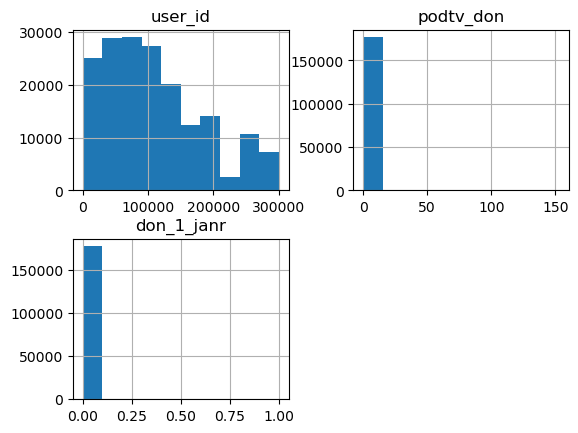

In [17]:
#рассмотрим зависимость между датой последней активности "Не указано" и количеством донаций
users[users['dt_last_act']== 'Не указано'].hist()
plt.show();

**Промежуточные выводы**

Мы видим, что подтвержденные донации и донации с 1 января полностью друг друга дублируют. Я бы рассматривала этих пользователей как спящих доноров, так как не понятно когда они последний раз заходили на сайт. Посчитаем процентное соотношение одних к другим.

In [18]:
#Подсчитаем сколько в исходном датафрейме информации о пользователей с неуказанной датой последней активности
#создадим датафрейм
not_dt = users[users['dt_last_act']== 'Не указано']
# сохраняем количество строк в исходном DataFrame
num_rows_before = len(users)

# сохраняем количество строк в обработанном DataFrame
num_rows_after = len(not_dt)

# вычисляем процент потерянных данных
percent_lost = (num_rows_before - num_rows_after) / num_rows_before * 100
print("Процент пользователей с неуказанной датой: {:.2f}%".format(percent_lost))

Процент пользователей с неуказанной датой: 38.30%


**Промежуточные выводы**

**Таких пользователей 38.30% отнесем их к классу спящие доноры** не смотря на то, что у *некоторых* пользователей есть подтвержденные донации, когда они заходили последний раз на сайт не понятно.

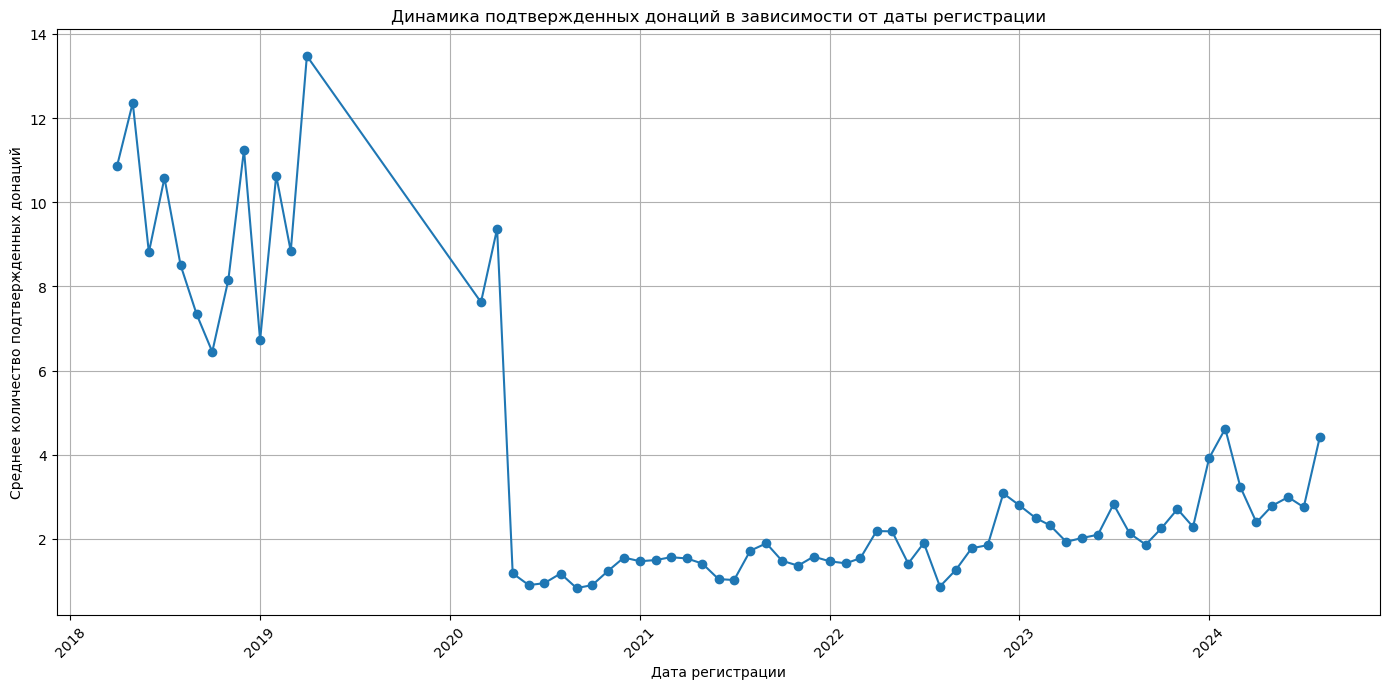

In [19]:
#Рассмотрим динамику между датой регистрации и количеством донаций.

# Отсечем 38.30% без указания последней даты регистрации
users_f = users[users['dt_last_act']!= 'Не указано']

#переведем даты в нужный формат
users_f['dt_reg'] = pd.to_datetime(users_f['dt_reg'], errors='coerce')

#Извлечение компонентов даты
users_f['year'] = users_f['dt_reg'].dt.year.astype(int)
users_f['month'] = users_f['dt_reg'].dt.month.astype(int)

# группировка по дате и расчет количества донаций

complication_rate = users_f.groupby(['year', 'month'])['podtv_don'].mean().reset_index()

#создаем новый столбец с корректным форматом

complication_rate['donation_reg'] = pd.to_datetime(complication_rate['year'].astype(str)+ '-' +
                                                   complication_rate['month'].astype(str).str.zfill(2) + '-01',
                                                   format= '%Y-%m-%d'
)

# Визуализация

plt.figure(figsize=(14,7))
plt.plot(complication_rate['donation_reg'], complication_rate['podtv_don'], marker ='o')
plt.xticks(rotation=45)
plt.xlabel('Дата регистрации')
plt.ylabel('Среднее количество подтвержденных донаций')
plt.title('Динамика подтвержденных донаций в зависимости от даты регистрации')
plt.grid(True)
plt.tight_layout()
plt.show()

**Промежуточные выводы**

Мы видим неравномерные скачки с 2018  по первыую треть 2020 года. В среднем пользователи подгружают 1-2 справки, в редких случаях 3 - 4.

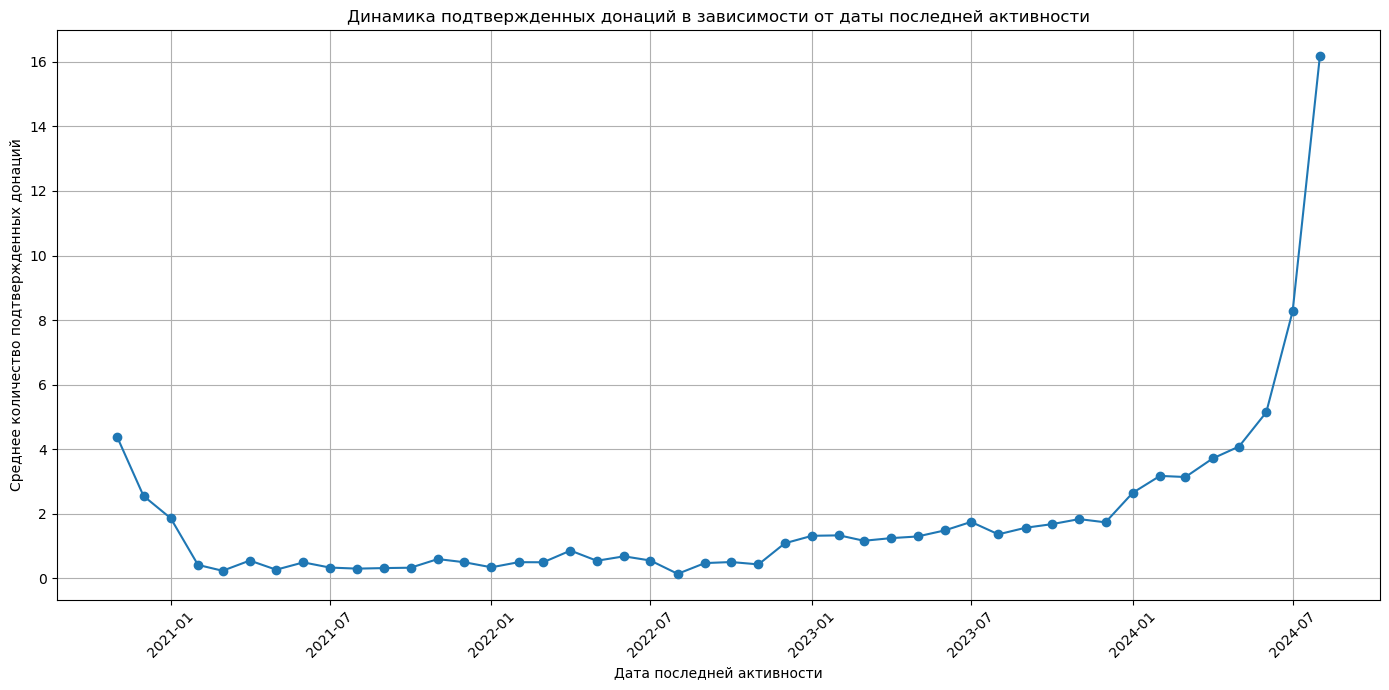

In [20]:
#Рассмотрим динамику между датой последней активности и количеством донаций.

# Отсечем 38.30% без указания последней даты регистрации
users_f = users[users['dt_last_act']!= 'Не указано']

#переведем даты в нужный формат
users_f['dt_last_act'] = pd.to_datetime(users_f['dt_last_act'], errors='coerce')

#Извлечение компонентов даты
users_f['year'] = users_f['dt_last_act'].dt.year.astype(int)
users_f['month'] = users_f['dt_last_act'].dt.month.astype(int)

# группировка по дате и расчет количества донаций

complication_rate_ac = users_f.groupby(['year', 'month'])['podtv_don'].mean().reset_index()

#создаем новый столбец с корректным форматом

complication_rate_ac['donation_last'] = pd.to_datetime(complication_rate_ac['year'].astype(str)+ '-' +
                                                   complication_rate_ac['month'].astype(str).str.zfill(2) + '-01',
                                                   format= '%Y-%m-%d'
)

# Визуализация

plt.figure(figsize=(14,7))
plt.plot(complication_rate_ac['donation_last'], complication_rate_ac['podtv_don'], marker ='o')
plt.xticks(rotation=45)
plt.xlabel('Дата последней активности')
plt.ylabel('Среднее количество подтвержденных донаций')
plt.title('Динамика подтвержденных донаций в зависимости от даты последней активности')
plt.grid(True)
plt.tight_layout()
plt.show()

**Промежуточные выводы**

Даты последних активностей у нас появляются с января 2021 года, на три года позже, чем регистрации. 
Для анализа возьмем данные по регистрациям и датам последних активностей с января 2021 года по январь 2024 потому что в этом промежутке нет резких скачков по количеству подтвержденных донаций.

In [21]:
users_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109893 entries, 0 to 286910
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      109893 non-null  int64         
 1   dt_reg       109893 non-null  object        
 2   dt_last_act  109893 non-null  datetime64[ns]
 3   podtv_don    109893 non-null  int64         
 4   don_1_janr   109893 non-null  int64         
 5   channel      109893 non-null  object        
 6   year         109893 non-null  int64         
 7   month        109893 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 7.5+ MB


In [22]:
# переводим дату регистрации в формат даты
users_f['dt_reg'] = pd.to_datetime(users_f['dt_reg'], errors='coerce')

**Промежуточные выводы**

Мы подготовили таблицу `users_f` к дальнейшему анализу пока по датам не будем отфильтровывать, посмотрим еще один датафрейм и решим как действовать дальше.

In [23]:
#переименовываем столбцы donation
donation =donation.rename(columns={'id_пользователя': 'user_id'
                                    ,'дата_донации': 'dt_real'
                                    ,'дата_добавления_донации': 'dt_serv'
                                    ,'статус_донации':'status'
                                   })
donation

,user_id,dt_real,dt_serv,status
0,210974,22.11.2023,25.08.2024,На модерации
1,146460,16.08.2024,25.08.2024,На модерации
2,292587,24.08.2024,25.08.2024,На модерации
3,300322,23.08.2024,25.08.2024,На модерации
4,300322,07.05.2024,25.08.2024,На модерации
...,...,...,...,...
355929,2071,28.11.2017,18.11.2020,Без справки
355930,116485,10.04.2018,18.11.2020,Без справки
355931,116485,10.04.2018,18.11.2020,Без справки
355932,116485,10.04.2018,18.11.2020,Без справки


In [24]:
# Группа с принятыми справками
donation_yes = donation.query('status == "Принята"')[['user_id','dt_real', 'dt_serv']]
donation_yes

,user_id,dt_real,dt_serv
5,296491,30.04.2013,25.08.2024
6,296491,30.04.2013,25.08.2024
8,296491,09.09.2019,25.08.2024
9,296491,09.09.2019,25.08.2024
10,296491,09.09.2019,25.08.2024
...,...,...,...
355909,116722,16.03.2016,18.11.2020
355910,123892,29.01.2018,18.11.2020
355914,140781,23.06.2017,18.11.2020
355915,13557,12.02.2014,18.11.2020


In [25]:
# объединим два датафрейма в один по user_id
merge_df = users_f.merge(donation_yes, on='user_id')
merge_df[:2]

,user_id,dt_reg,dt_last_act,podtv_don,don_1_janr,channel,year,month,dt_real,dt_serv
0,300297,2024-08-25,2024-08-25,1,1,['CardsMobile'],2024,8,14.08.2024,25.08.2024
1,300281,2024-08-24,2024-08-24,20,3,['MainPage'],2024,8,10.11.2017,24.08.2024


In [26]:
# проверяем наличие дубликатов
merge_df.duplicated().sum()

41258

In [27]:
# для корректного анализа данных удаляем дубликаты
merge_df = merge_df.drop_duplicates().reset_index(drop = True)

In [28]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234128 entries, 0 to 234127
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      234128 non-null  int64         
 1   dt_reg       234128 non-null  datetime64[ns]
 2   dt_last_act  234128 non-null  datetime64[ns]
 3   podtv_don    234128 non-null  int64         
 4   don_1_janr   234128 non-null  int64         
 5   channel      234128 non-null  object        
 6   year         234128 non-null  int64         
 7   month        234128 non-null  int64         
 8   dt_real      234128 non-null  object        
 9   dt_serv      234128 non-null  object        
dtypes: datetime64[ns](2), int64(5), object(3)
memory usage: 17.9+ MB


In [29]:
# переводим даты в форматы дат
merge_df['dt_real'] = pd.to_datetime(merge_df['dt_real'], errors='coerce')
merge_df['dt_serv'] = pd.to_datetime(merge_df['dt_serv'], errors='coerce')
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234128 entries, 0 to 234127
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      234128 non-null  int64         
 1   dt_reg       234128 non-null  datetime64[ns]
 2   dt_last_act  234128 non-null  datetime64[ns]
 3   podtv_don    234128 non-null  int64         
 4   don_1_janr   234128 non-null  int64         
 5   channel      234128 non-null  object        
 6   year         234128 non-null  int64         
 7   month        234128 non-null  int64         
 8   dt_real      234128 non-null  datetime64[ns]
 9   dt_serv      234128 non-null  datetime64[ns]
dtypes: datetime64[ns](4), int64(5), object(1)
memory usage: 17.9+ MB


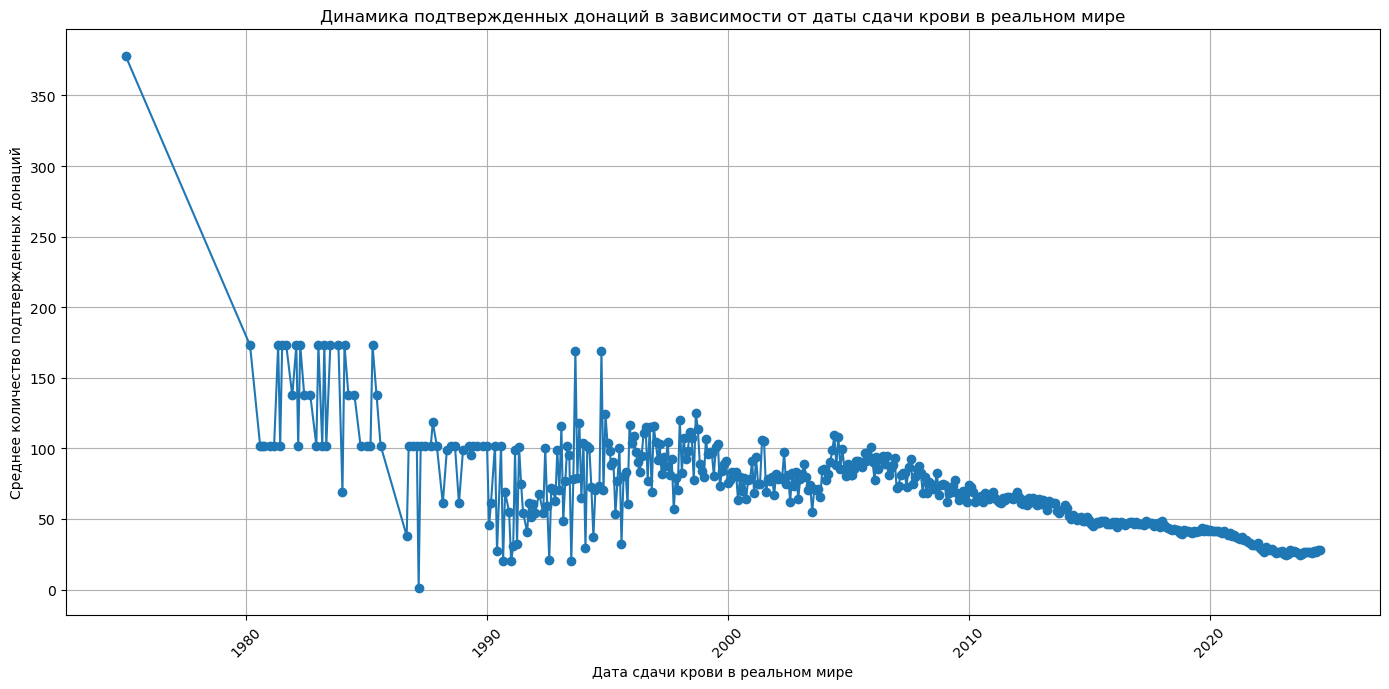

In [30]:
#Рассмотрим динамику датой сдачи крови в реальном мире и количеством донаций.

#Извлечение компонентов даты
merge_df['year_real'] = merge_df['dt_real'].dt.year.astype(int)
merge_df['month_real'] = merge_df['dt_real'].dt.month.astype(int)

# группировка по дате и расчет количества донаций

complication = merge_df.groupby(['year_real', 'month_real'])['podtv_don'].mean().reset_index()

#создаем новый столбец с корректным форматом

complication['donation_last'] = pd.to_datetime(complication['year_real'].astype(str)+ '-' +
                                                   complication['month_real'].astype(str).str.zfill(2) + '-01',
                                                   format= '%Y-%m-%d'
)

# Визуализация

plt.figure(figsize=(14,7))
plt.plot(complication['donation_last'], complication['podtv_don'], marker ='o')
plt.xticks(rotation=45)
plt.xlabel('Дата сдачи крови в реальном мире')
plt.ylabel('Среднее количество подтвержденных донаций')
plt.title('Динамика подтвержденных донаций в зависимости от даты сдачи крови в реальном мире')
plt.grid(True)
plt.tight_layout()
plt.show()

**Промежуточные выводы**

На графике средние количества подтвержденных донаций о сдачи крови в реальном мире с 1980 года очень неровное, есть аномальные значения.

Заказчик говорил, что некоторые пользователи не размечают свои донации по датам и сервис может принять несколько донаций датой, когда еще не существовало сервиса.

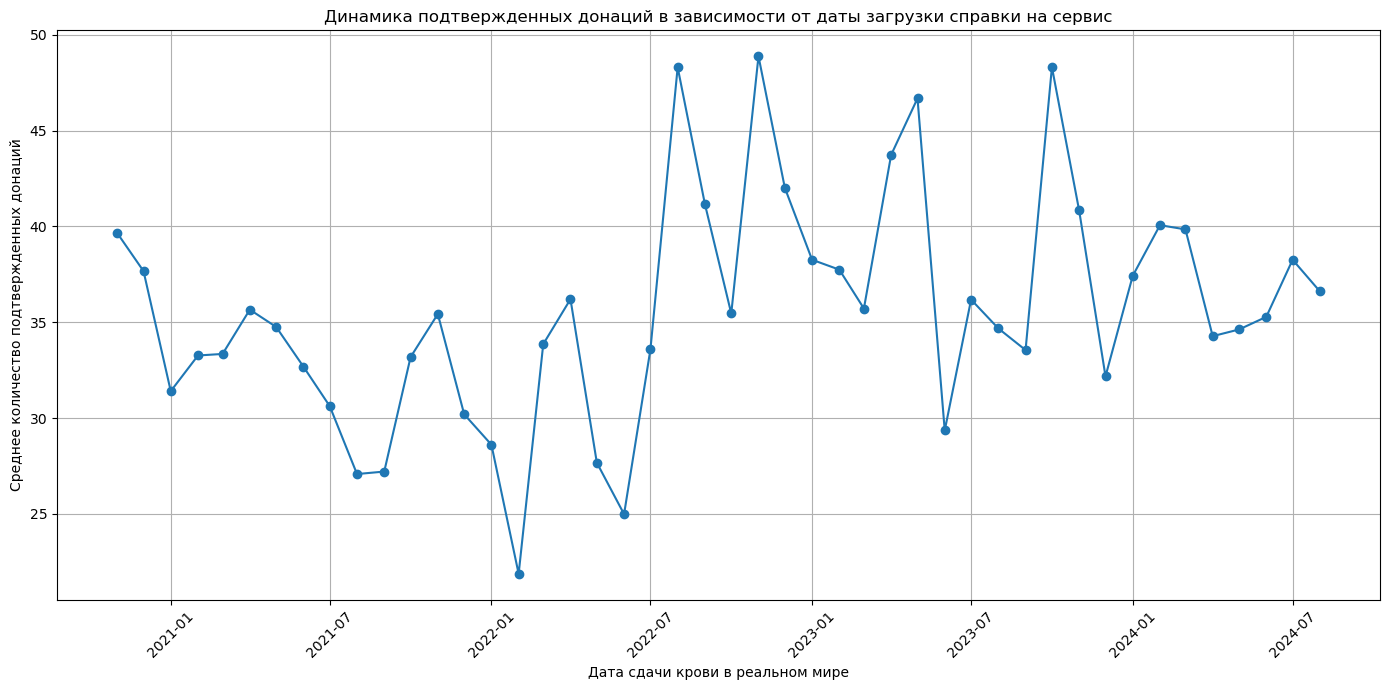

In [31]:
#Рассмотрим динамику датой подгрузки справки и количеством донаций.

#Извлечение компонентов даты
merge_df['year_serv'] = merge_df['dt_serv'].dt.year.astype(int)
merge_df['month_serv'] = merge_df['dt_serv'].dt.month.astype(int)

# группировка по дате и расчет количества донаций

complication_serv = merge_df.groupby(['year_serv', 'month_serv'])['podtv_don'].mean().reset_index()

#создаем новый столбец с корректным форматом

complication_serv['donation_last'] = pd.to_datetime(complication_serv['year_serv'].astype(str)+ '-' +
                                                   complication_serv['month_serv'].astype(str).str.zfill(2) + '-01',
                                                   format= '%Y-%m-%d'
)

# Визуализация

plt.figure(figsize=(14,7))
plt.plot(complication_serv['donation_last'], complication_serv['podtv_don'], marker ='o')
plt.xticks(rotation=45)
plt.xlabel('Дата сдачи крови в реальном мире')
plt.ylabel('Среднее количество подтвержденных донаций')
plt.title('Динамика подтвержденных донаций в зависимости от даты загрузки справки на сервис')
plt.grid(True)
plt.tight_layout()
plt.show()

**Промежуточные выводы**

На графике средние количества подтвержденных донаций о подгрузке справок колеблятся с января 2021 года по январь 2024 год  от 0 до 2.

Будем рассматривать данные с января 2021 года по январь 2024 год. Доноров которые не войдут в наш анализ будем считать неактивными, так как с 2018 года до 2021 год прошло 3 года, а сведений у нас нет. 
Будем рассматривать зарегистрированных доноров с января 2021 по январь 2023.

In [32]:
# фильтрация данных по дате регистрации
merge_df_filt= merge_df[(merge_df['dt_reg'] > '2020-12-31') &(merge_df['dt_reg'] < '2023-11-01')]
print('Минимальная дата регистрации', (merge_df_filt['dt_reg'].min()))
print('Максимальная дата регистрации', (merge_df_filt['dt_reg'].max()))

Минимальная дата регистрации 2021-01-01 00:00:00
Максимальная дата регистрации 2023-10-31 00:00:00


In [33]:
#Подсчитаем сколько пользователей мы отсеяли

# сохраняем количество строк в исходном DataFrame
num_rows_before = len(merge_df)

# сохраняем количество строк в обработанном DataFrame
num_rows_after = len(merge_df_filt)

# вычисляем процент потерянных данных
percent_lost = (num_rows_before - num_rows_after) / num_rows_before * 100
print("Пользователи не попавшие в датафрейм, зарегестрированные до 1 января 2021 года и после 1 ноября 2023: {:.2f}%".format(percent_lost))

Пользователи не попавшие в датафрейм, зарегестрированные до 1 января 2021 года и после 1 ноября 2023: 50.53%


# Вывод по предобработке данных:

- Для предобработки я выбрала 2 детефрейма `users_anon_data` и `donations_anon` выбрала столбцы удалила дубликаты.
- Пользователей у кого не указана дата последней активности отсеяла это 38% и присвоила им кластер **потерянный донор**, так как некоторые из них зарегестрировались и больше не посещали сайт, по другим данные могли быть утеряны при переезде сайта.
- Объединила датафреймы отобрав записи о пользователях кто зарегестрировался в период с `2021-01-01` по `2023-11-01`

## Анализ данных

In [34]:
# посмотрим распределение донаций
merge_df_filt['podtv_don'].describe()

count    115833.000000
mean         35.786080
std          39.385858
min           1.000000
25%           9.000000
50%          26.000000
75%          45.000000
max         378.000000
Name: podtv_don, dtype: float64

**Промежуточные выводы**

У нас в среднем на каждого пользователя приходится 26 подтвержденных донаций, а максимум 378. Все они зарегестрировались начиная с 2021 года.

[Я узнала](http://gburospk.ru/donoru/o-donorstve.php) чтобы не нанести вред своему здоровью донору необходимо выдерживать интервалы между процедурами сдачи крови. Цельную кровь можно сдавать один раз в два месяца, но не более 5 раз в год. Плазму или тромбоциты можно сдавать один раз в две недели.


[Про плазму](https://donor.blood.ru/types-donation/plasma-donation.php#:~:text=%D0%9F%D1%80%D0%BE%D1%86%D0%B5%D0%B4%D1%83%D1%80%D0%B0%20%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B3%D0%BE%20%D0%BF%D0%BB%D0%B0%D0%B7%D0%BC%D0%B0%D1%84%D0%B5%D1%80%D0%B5%D0%B7%D0%B0%20%D1%81%D0%BE%D1%81%D1%82%D0%BE%D0%B8%D1%82%20%D0%B8%D0%B7,%D0%B2%D0%BE%D0%B7%D0%B2%D1%80%D0%B0%D1%82%20%D0%BA%D0%BB%D0%B5%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D1%85%20%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82%D0%BE%D0%B2%20%D0%BA%D1%80%D0%BE%D0%B2%D0%B8) я прочитала, что ее разрешается сдавать через каждые 14 дней. После 5 регулярных автоматических плазмаферезов следует перерыв 1 месяц, после 10 — 2 месяца.

В году 52 недели - если сдавать плазму каждые 2 недели с перерывамив 4 недели, то в год максимум можно сдать 20 раз плазму. Есть люди, которым нельзя сдавать кровь, у них чаще всего положительный kell и у них берут только плазму.

Удалим из датафрейма аномальные значения - больше максимума.

In [35]:
index_of_age_anomaly = merge_df_filt[merge_df_filt['podtv_don'] >= 100].index
merge_df_filt.drop(index_of_age_anomaly, inplace = True)

In [36]:
# посмотрим распределение донаций
merge_df_filt['podtv_don'].describe()

count    106927.000000
mean         27.076519
std          21.985608
min           1.000000
25%           8.000000
50%          23.000000
75%          40.000000
max          99.000000
Name: podtv_don, dtype: float64

**Промежуточные выводы**

Выделим группы на основе наших наблюдений:

- от 1 до 3 донаций `not_activ_donor`если человек сдал кровь 1-3 раза и больше не сдает, его можно считать не активным донором, которого можно оживить выслав персонализированную рекламу ему на почту.
- от 4 до 8 донаций `sleep_donor` если человек сдал кровь 4-8 раз и больше не сдает он спящий - возможно какие-то другие причины
- от 9 до 27 `active_donor` человек регулярно сдает кровь.
- больше 28 раз `pro_active_donor` человек больше 28 раз сдал кровь, для него это важно.

In [37]:
def donor_group(indicator) :
    if 1 <= indicator <= 3:
        return  'not_activ_donor'
    if 4 <= indicator <= 8 :
        return 'sleep_donor'
    if 9 <= indicator <= 27:
        return 'active_donor'
    if indicator > 28:
        return 'pro_active_donor'
        
merge_df_filt['donor_group'] = merge_df_filt['podtv_don'].apply(donor_group)
merge_df_filt

,user_id,dt_reg,dt_last_act,podtv_don,don_1_janr,channel,year,month,dt_real,dt_serv,year_real,month_real,year_serv,month_serv,donor_group
44085,273673,2023-10-31,2024-03-18,1,0,[None],2024,3,2023-10-16,2023-10-31,2023,10,2023,10,not_activ_donor
44086,273664,2023-10-31,2023-11-01,1,0,['MainPage'],2023,11,2023-10-31,2023-10-31,2023,10,2023,10,not_activ_donor
44087,273655,2023-10-31,2024-08-23,3,1,['MainPage'],2024,8,2024-04-23,2024-06-01,2024,4,2024,6,not_activ_donor
44088,273655,2023-10-31,2024-08-23,3,1,['MainPage'],2024,8,2023-12-19,2023-12-24,2023,12,2023,12,not_activ_donor
44089,273655,2023-10-31,2024-08-23,3,1,['MainPage'],2024,8,2023-10-19,2023-10-31,2023,10,2023,10,not_activ_donor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159913,154192,2021-01-01,2024-08-21,9,1,[None],2024,8,2021-03-22,2021-04-05,2021,3,2021,4,active_donor
159914,154192,2021-01-01,2024-08-21,9,1,[None],2024,8,2020-02-22,2021-01-05,2020,2,2021,1,active_donor
159915,154192,2021-01-01,2024-08-21,9,1,[None],2024,8,2019-12-25,2021-01-05,2019,12,2021,1,active_donor
159916,154192,2021-01-01,2024-08-21,9,1,[None],2024,8,2021-01-05,2021-01-05,2021,1,2021,1,active_donor


In [38]:
# Исследуем соотношение пользователей по группам доноров. Построим график.

user_by_group = (
    merge_df_filt
    .groupby('donor_group')
    .agg(count=('user_id','count'))
    .reset_index()
    .sort_values('count', ascending=False)
)

user_by_group['percent'] = round((user_by_group['count'] / sum(user_by_group['count']) * 100),1)

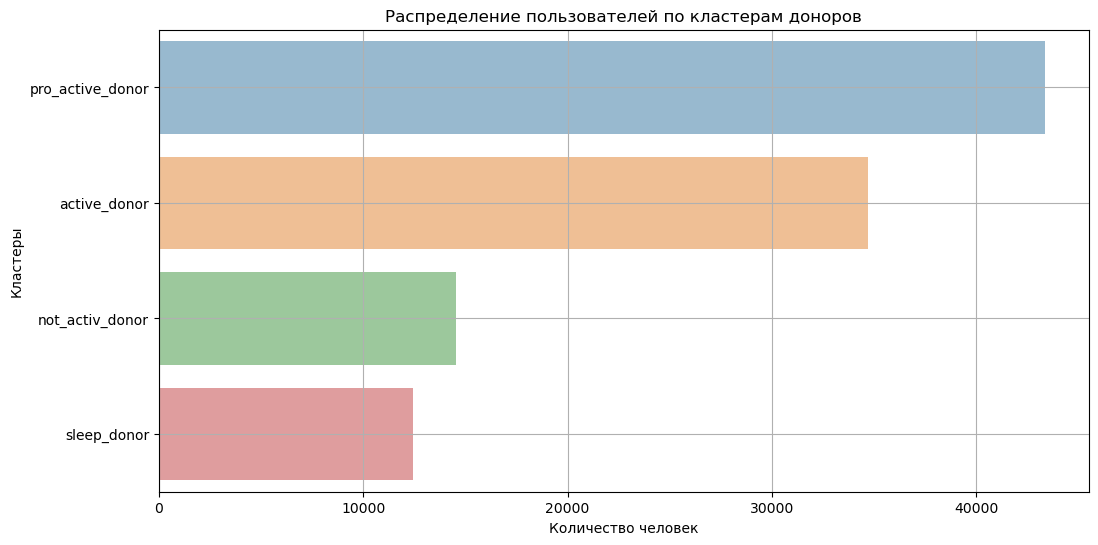

In [39]:
# строим график

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='count', y='donor_group', 
                 data=user_by_group, 
                 orient='h', alpha=0.5)
ax.set_title('Распределение пользователей по кластерам доноров')
ax.set_xlabel('Количество человек') 
ax.set_ylabel('Кластеры')
plt.grid(True)
plt.show()

**Промежуточный вывод**

- Лидеры по использованиию сревиса доноры, у которых больше 28 донаций.
- Второе место занимают доноры у кого от 9 до 27 подтвержденных донаций
- не активных и спящих доноров примерно поровну.

In [40]:
# Посмотрм на данные до фильтрации
merge_df

,user_id,dt_reg,dt_last_act,podtv_don,don_1_janr,channel,year,month,dt_real,dt_serv,year_real,month_real,year_serv,month_serv
0,300297,2024-08-25,2024-08-25,1,1,['CardsMobile'],2024,8,2024-08-14,2024-08-25,2024,8,2024,8
1,300281,2024-08-24,2024-08-24,20,3,['MainPage'],2024,8,2017-11-10,2024-08-24,2017,11,2024,8
2,300281,2024-08-24,2024-08-24,20,3,['MainPage'],2024,8,2018-05-10,2024-08-24,2018,5,2024,8
3,300281,2024-08-24,2024-08-24,20,3,['MainPage'],2024,8,2018-07-25,2024-08-24,2018,7,2024,8
4,300281,2024-08-24,2024-08-24,20,3,['MainPage'],2024,8,2018-09-26,2024-08-24,2018,9,2024,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234123,9322,2018-04-09,2024-08-17,39,6,[None],2024,8,2022-05-06,2022-05-06,2022,5,2022,5
234124,9322,2018-04-09,2024-08-17,39,6,[None],2024,8,2022-02-07,2022-02-07,2022,2,2022,2
234125,9322,2018-04-09,2024-08-17,39,6,[None],2024,8,2021-12-24,2021-12-24,2021,12,2021,12
234126,9322,2018-04-09,2024-08-17,39,6,[None],2024,8,2014-08-22,2020-11-18,2014,8,2020,11


In [41]:
def donor_group(indicator) :
    if 1 <= indicator <= 3:
        return  'not_activ_donor'
    if 4 <= indicator <= 8 :
        return 'sleep_donor'
    if 9 <= indicator <= 27:
        return 'active_donor'
    if indicator > 28:
        return 'pro_active_donor'
        
merge_df['donor_group'] = merge_df['podtv_don'].apply(donor_group)
merge_df

,user_id,dt_reg,dt_last_act,podtv_don,don_1_janr,channel,year,month,dt_real,dt_serv,year_real,month_real,year_serv,month_serv,donor_group
0,300297,2024-08-25,2024-08-25,1,1,['CardsMobile'],2024,8,2024-08-14,2024-08-25,2024,8,2024,8,not_activ_donor
1,300281,2024-08-24,2024-08-24,20,3,['MainPage'],2024,8,2017-11-10,2024-08-24,2017,11,2024,8,active_donor
2,300281,2024-08-24,2024-08-24,20,3,['MainPage'],2024,8,2018-05-10,2024-08-24,2018,5,2024,8,active_donor
3,300281,2024-08-24,2024-08-24,20,3,['MainPage'],2024,8,2018-07-25,2024-08-24,2018,7,2024,8,active_donor
4,300281,2024-08-24,2024-08-24,20,3,['MainPage'],2024,8,2018-09-26,2024-08-24,2018,9,2024,8,active_donor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234123,9322,2018-04-09,2024-08-17,39,6,[None],2024,8,2022-05-06,2022-05-06,2022,5,2022,5,pro_active_donor
234124,9322,2018-04-09,2024-08-17,39,6,[None],2024,8,2022-02-07,2022-02-07,2022,2,2022,2,pro_active_donor
234125,9322,2018-04-09,2024-08-17,39,6,[None],2024,8,2021-12-24,2021-12-24,2021,12,2021,12,pro_active_donor
234126,9322,2018-04-09,2024-08-17,39,6,[None],2024,8,2014-08-22,2020-11-18,2014,8,2020,11,pro_active_donor


In [42]:
# Исследуем соотношение пользователей по группам доноров. Построим график.

user_by_group = (
    merge_df
    .groupby('donor_group')
    .agg(count=('user_id','count'))
    .reset_index()
    .sort_values('count', ascending=False)
)

user_by_group['percent'] = round((user_by_group['count'] / sum(user_by_group['count']) * 100),1)

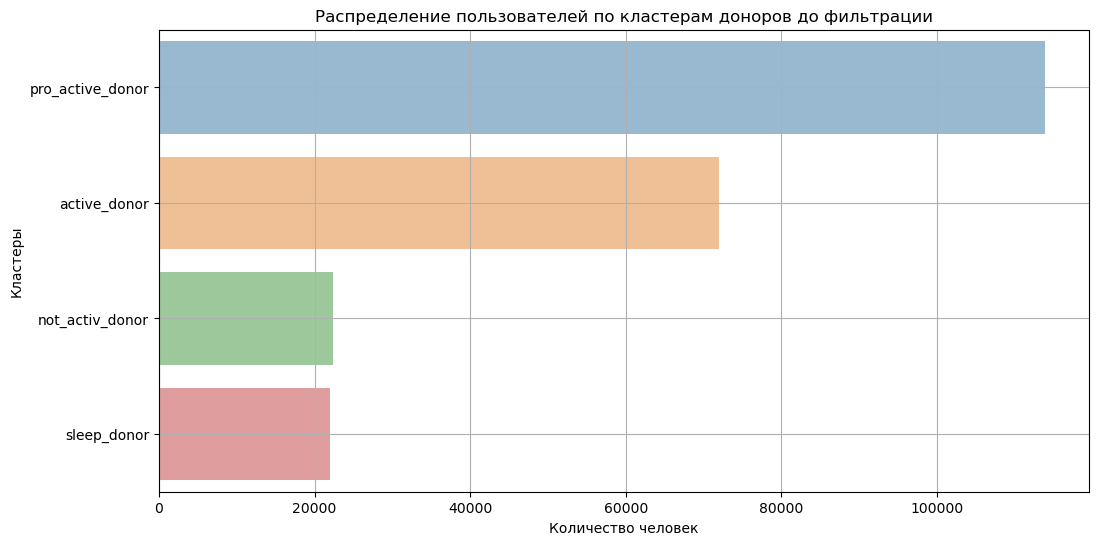

In [43]:
# строим график

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='count', y='donor_group', 
                 data=user_by_group, 
                 orient='h', alpha=0.5)
ax.set_title('Распределение пользователей по кластерам доноров до фильтрации')
ax.set_xlabel('Количество человек') 
ax.set_ylabel('Кластеры')
plt.grid(True)
plt.show()

In [44]:
# Исследуем соотношение пользователей по приходу с разных каналов. Построим график.

user_by_channel = (
    merge_df
    .groupby('channel')
    .agg(count=('user_id','count'))
    .reset_index()
    .sort_values('count', ascending=False)
)

user_by_channel['percent'] = round((user_by_channel['count'] / sum(user_by_channel['count']) * 100),1)

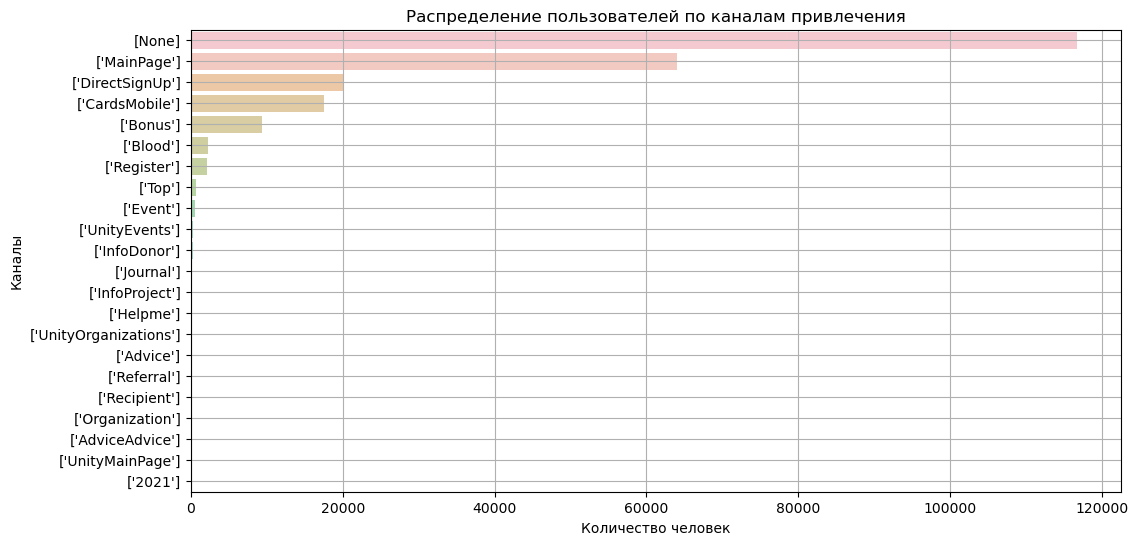

In [45]:
# строим график

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='count', y='channel', 
                 data=user_by_channel, 
                 orient='h', alpha=0.5)
ax.set_title('Распределение пользователей по каналам привлечения')
ax.set_xlabel('Количество человек') 
ax.set_ylabel('Каналы')
plt.grid(True)
plt.show()

**Промежуточный вывод**

- Мы не знаем откуда приходят доноры на сервис - это не указано в тегах `None` 
- Второе место занимает переход с главной страницы.
- Третье место - прямая регистрация.

In [46]:
# вычисляем лайфтайм для каждого пользователя в днях от дня регистрации и дня последней активности

merge_df_filt['lifetime'] = (
    merge_df_filt['dt_last_act'] - merge_df_filt['dt_reg']
).dt.days

merge_df_filt.head(5)

,user_id,dt_reg,dt_last_act,podtv_don,don_1_janr,channel,year,month,dt_real,dt_serv,year_real,month_real,year_serv,month_serv,donor_group,lifetime
44085,273673,2023-10-31,2024-03-18,1,0,[None],2024,3,2023-10-16,2023-10-31,2023,10,2023,10,not_activ_donor,139
44086,273664,2023-10-31,2023-11-01,1,0,['MainPage'],2023,11,2023-10-31,2023-10-31,2023,10,2023,10,not_activ_donor,1
44087,273655,2023-10-31,2024-08-23,3,1,['MainPage'],2024,8,2024-04-23,2024-06-01,2024,4,2024,6,not_activ_donor,297
44088,273655,2023-10-31,2024-08-23,3,1,['MainPage'],2024,8,2023-12-19,2023-12-24,2023,12,2023,12,not_activ_donor,297
44089,273655,2023-10-31,2024-08-23,3,1,['MainPage'],2024,8,2023-10-19,2023-10-31,2023,10,2023,10,not_activ_donor,297


In [47]:
merge_df_filt['lifetime'].describe()

count    106927.000000
mean        516.531194
std         318.410559
min        -102.000000
25%         296.000000
50%         532.000000
75%         736.000000
max        1328.000000
Name: lifetime, dtype: float64

In [48]:
merge_df_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106927 entries, 44085 to 159917
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      106927 non-null  int64         
 1   dt_reg       106927 non-null  datetime64[ns]
 2   dt_last_act  106927 non-null  datetime64[ns]
 3   podtv_don    106927 non-null  int64         
 4   don_1_janr   106927 non-null  int64         
 5   channel      106927 non-null  object        
 6   year         106927 non-null  int64         
 7   month        106927 non-null  int64         
 8   dt_real      106927 non-null  datetime64[ns]
 9   dt_serv      106927 non-null  datetime64[ns]
 10  year_real    106927 non-null  int64         
 11  month_real   106927 non-null  int64         
 12  year_serv    106927 non-null  int64         
 13  month_serv   106927 non-null  int64         
 14  donor_group  105056 non-null  object        
 15  lifetime     106927 non-null  int64

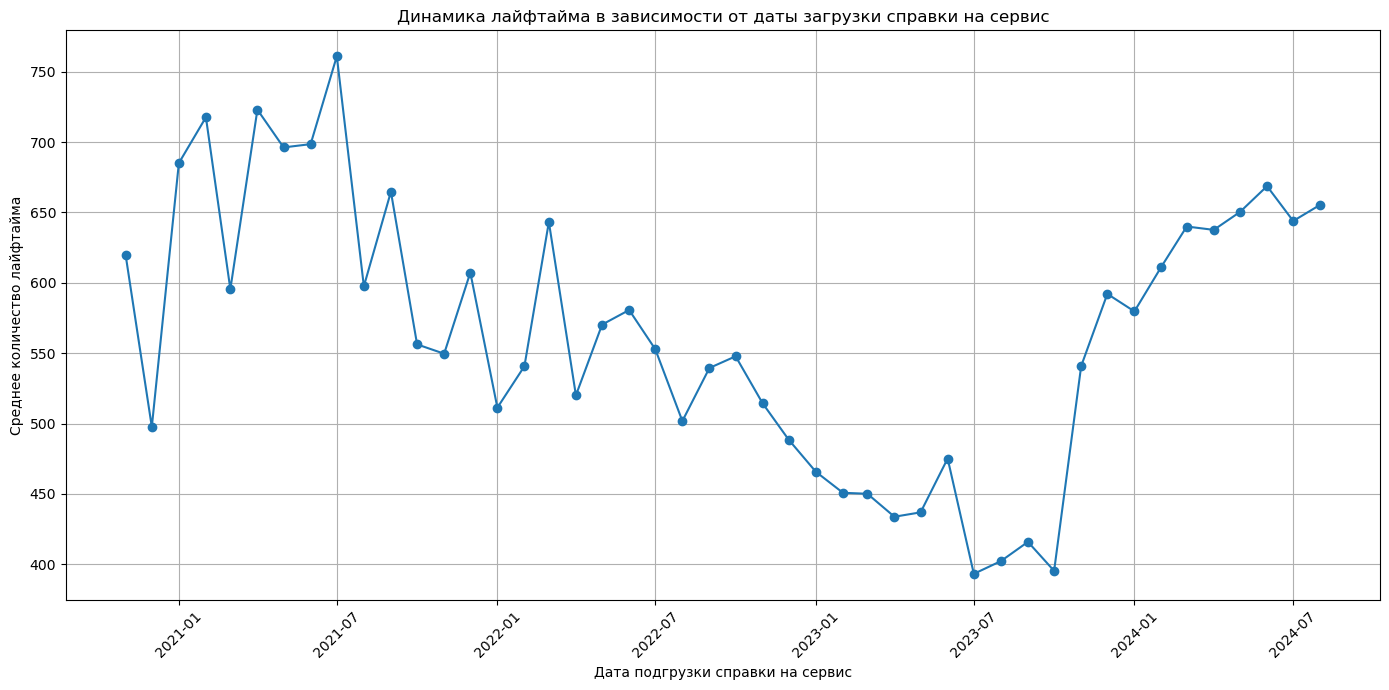

In [49]:
#Рассмотрим динамику датой подгрузки справки и лайфтаймом.

# группировка по дате и расчет количества донаций

complication_serv_life_time = merge_df_filt.groupby(['year_serv', 'month_serv'])['lifetime'].mean().reset_index()

#создаем новый столбец с корректным форматом

complication_serv_life_time['donation_last_life_time'] = pd.to_datetime(complication_serv['year_serv'].astype(str)+ '-' +
                                                   complication_serv['month_serv'].astype(str).str.zfill(2) + '-01',
                                                   format= '%Y-%m-%d'
)

# Визуализация

plt.figure(figsize=(14,7))
plt.plot(complication_serv_life_time['donation_last_life_time'], complication_serv_life_time['lifetime'], marker ='o')
plt.xticks(rotation=45)
plt.xlabel('Дата подгрузки справки на сервис')
plt.ylabel('Среднее количество лайфтайма')
plt.title('Динамика лайфтайма в зависимости от даты загрузки справки на сервис')
plt.grid(True)
plt.tight_layout()
plt.show()

**Промежуточный вывод**

- Динамика времени «жизни» пользователя относительно даты старта нестабильна. 
- [Почитала в комментариях](https://vk.com/wall-21179173_135919), что отношение к донорам неоднозначное, возможно кто-то не может регулярно пользоваться сервисом из за боязни осуждения.

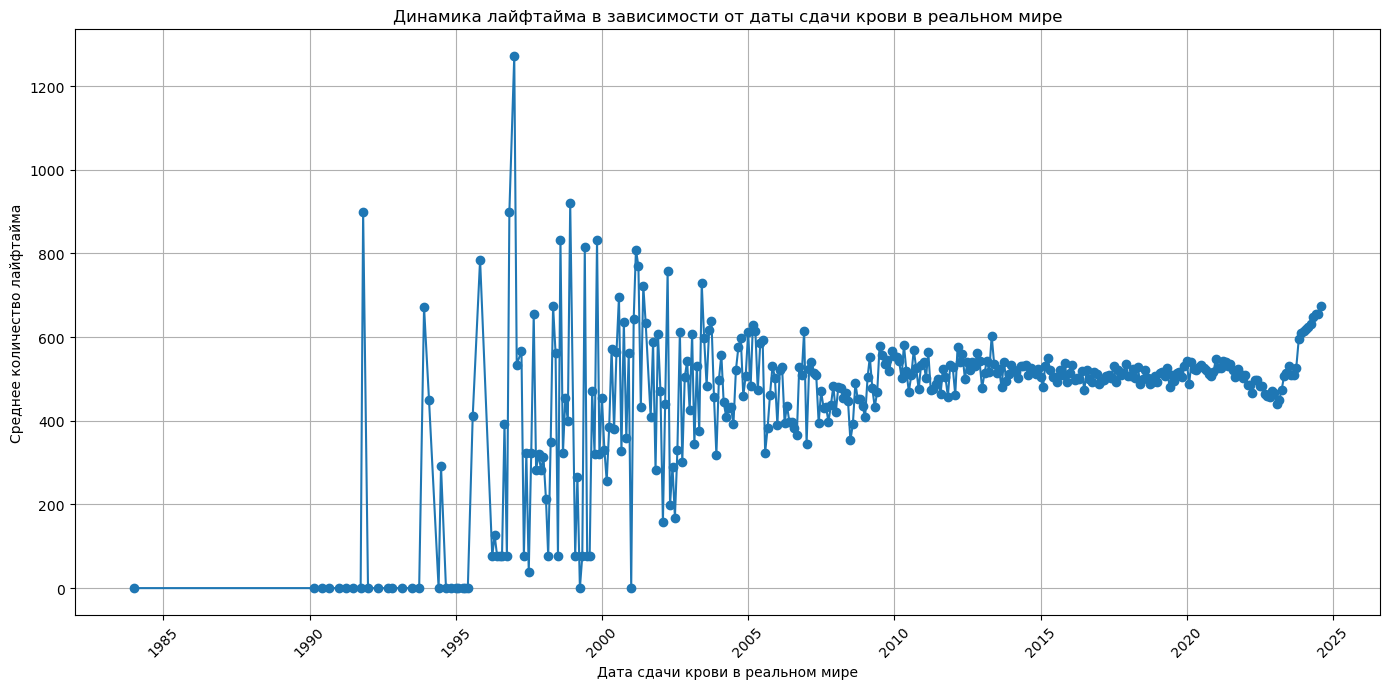

In [50]:
#Рассмотрим динамику датой сдачи крови и лайфтаймом

# группировка по дате и расчет количества донаций

complication_real_life_time = merge_df_filt.groupby(['year_real', 'month_real'])['lifetime'].mean().reset_index()

#создаем новый столбец с корректным форматом

complication_real_life_time['donation_last_life_time'] = pd.to_datetime(complication_real_life_time['year_real'].astype(str)+ '-' +
                                                   complication_real_life_time['month_real'].astype(str).str.zfill(2) + '-01',
                                                   format= '%Y-%m-%d'
)

# Визуализация

plt.figure(figsize=(14,7))
plt.plot(complication_real_life_time['donation_last_life_time'], complication_real_life_time['lifetime'], marker ='o')
plt.xticks(rotation=45)
plt.xlabel('Дата сдачи крови в реальном мире')
plt.ylabel('Среднее количество лайфтайма')
plt.title('Динамика лайфтайма в зависимости от даты сдачи крови в реальном мире')
plt.grid(True)
plt.tight_layout()
plt.show()

**Промежуточный вывод**

- Заказчик говорил, что на сервисе могут регистрироваться люди у кого на момент регистрации были донации подтвержденные справками и не все из пользователей их размечают по датам, и тогда донации принимают одной старой датой из-за этого как мы видим на графике нет какой-то стабильности и наглядности.

# Заключение

- Лидеры по использованиию сревиса доноры, у которых больше 28 донаций.
- Второе место занимают доноры у кого от 9 до 27 подтвержденных донаций
- не активных и спящих доноров примерно поровну - у них от 0 до 8 донаций
- Из-за переезда сайта нет информации о 38% зарегистрированных ранее людях.
- Не видно откуда приходят доноры.

**Рекомендации**

- Провести анкетирование среди всех зарегистрированных пользователей для того чтобы узнать откуда они пришли на сервис. Что можно было бы улучшить на сервисе.
- Для быстроты обработки анкетирование сделать с вариантами ответов и  добавить форму для свободных ответов [пример](https://www.survio.com/shablon-oprosa/otsenka-udovletvorennosti-produktom)